### imports

In [1]:
#imports 

import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd 
from sklearn.model_selection import train_test_split

### download the dataset from Kaggle

In [2]:
#!pip install opendatasets
import opendatasets as od

dataset= "https://www.kaggle.com/datasets/sriramm2010/uci-bike-sharing-data/download?datasetVersionNumber=1"
#"https://www.kaggle.com/datasets/zhangyunsheng/defects-class-and-location/download?datasetVersionNumber=1"
#od.download(dataset)

### Preprocessing

In [3]:
## global variables 


image_directory = os.path.join('.','dataset','images','images')
xml_directory = os.path.join('.','dataset','label','label')

defect_types_languages_list = { 
        '1_chongkong' : ('punching_hole','Stanzen'),'2_hanfeng' : ('welding_line','schweißbahn'),
        '3_yueyawan' : ('crescent_gap','sichelspalt'),'4_shuiban' : ('water_spot','wasserfleck'),
        '5_youban': ('oil_spot','ölfleck'),'6_siban': ('silk_spot','seidenfleck'),
        '7_yiwu' : ('inclusion','einschlüss'),'8_yahen' : ('rolled_pit','gewalzte_grube'),
        '9_zhehen' : ('crease','falten'),'10_yaozhed' : ('waist_folding','taillenfalten')
        }

defect_categories = {
        'punching_hole':0,
        'welding_line':1,
        'crescent_gap':2,
        'water_spot':3,
        'oil_spot':4,
        'silk_spot':5,
        'inclusion':6,
        'rolled_pit':7,
        'crease':8,
        'waist_folding':9,
        }

#### helper functions

In [9]:
def assign_language(word, word_to = 'eng'):
    # due to the dataset being in Chinese, we need to convert the defect types to English or German

    ret_value = None

    for key,value in defect_types_languages_list.items():
        if word in value:
            ret_value =  key
        elif word in key and word_to == 'ger':
            ret_value =  value[1]
        elif word in key and word_to == 'eng':
            ret_value =  value[0]

    return ret_value

def read_xml(xml_path: str) -> dict:
    
    tree_path = xml_path
    tree = ET.parse(tree_path)
    root = tree.getroot()

    filename = root.find('filename').text

    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    depth = int(root.find('size/depth').text)

    objects = root.findall('object')
    bbs = []
    defect_types=[]
    for obj in objects:
        
        name = obj.find('name').text
        defect_type = assign_language(name,'eng')
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        

#         incase one-hot-vector is needed
#         name = assign_language(name,'eng')
#         one_hot_vector = [0] * len(defect_categories)
#         defect_index = defect_categories[name]
#         one_hot_vector[defect_index] =1
        
        
        bbs.append([defect_categories[defect_type],xmin,ymin,xmax,ymax])
        defect_types.append(defect_type)
        
        
    return { 'dimensions'     : [width,height,depth],
             'bounding_boxes' : bbs,
            'defect_types':defect_types
           }
    
#np.random.seed(10)
def visualize_data(data_frame:pd.DataFrame,
                   defect_type = 'random' ,
                   show_new_data_point = True) -> None:
    """
    dictionary : dict
        default_value = image_path_pair
        the dictionary that contains the structure {'img_id' : (image_path,xml_path)}
    
    defect type :str
        default_value = 'random'
        of of 10 defect types avaliable in the dataset to choose from:
         english version : punching / welding_line / crescent_gap / water_spot / oil_spot / silk_spot / inclusion
                           rolled_pit / crease / waist
         german version : 
         
         
         
    show_new_data_point: bool
        default_value = True
        if value is True, the function shows a different data point each time it runs 
        if False, the functions stays on the first data point it showed 
    
    """

    
    if defect_type == 'random':
        sample = data_frame.sample()
    else:
        filtered_df = data_frame[data_frame['defect_types'].apply(lambda x: defect_type in x )]
        sample = filtered_df.sample()

    xml_path = sample['xml_path'].item()
    image_path = sample['img_path'].item()
        
    tree_path = xml_path
    tree = ET.parse(tree_path)
    root = tree.getroot()

    # Access and extract information from the XML elements
    filename = root.find('filename').text
    path = root.find('path').text

    objects = root.findall('object')

    image = Image.open(image_path)
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image,cmap='gray') #cmap='gray'
    print("Name            | xmin/ymin | xmax/ymax")
    # Plot bounding boxes
    for obj in objects:
        name = obj.find('name').text
        translated_name = assign_language(name,'eng')
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the axes
        ax.add_patch(rect)
        ax.text(xmin, ymin, translated_name, color='r', verticalalignment='top')

        print(f"{translated_name:15} | ({xmin:4},{ymin:4}) | ({xmax:4},{ymax:4})")
        
    # Set axis labels and title
    plt.axis('off')
    plt.title(f"filename: {filename}")

    # Show the image with bounding boxes
    plt.show()


In [10]:
# constructing a dictionary for assigning purposes 
# structure  : {image_id : (path_of_image,
#                           path of xml file)
#              } 
# example : {img_01_3436789500_00004.jpg : ('.\\dataset\\images\\images\\crease\\img_01_3436789500_00004.jpg',
#                                           '.\\dataset\\label\\label\\img_01_3436789500_00004.xml')
#           }


list_to_construct_dataframe = []

for folder in os.listdir(image_directory):
    
    for image in os.listdir(os.path.join(image_directory,folder)):
        
        img_path = os.path.join(image_directory, folder, image)
        xml_path = os.path.join(xml_directory, image.replace('jpg','xml'))
        
        if os.path.exists(img_path) and os.path.exists(xml_path):
            image_id = image.split('.')[0]
            xml_details = read_xml(xml_path)
            list_to_construct_dataframe.append([image_id,
                                                img_path,
                                                xml_path,
                                                xml_details['defect_types'],
                                                xml_details['dimensions'],
                                                xml_details['bounding_boxes']
                                               ])

df = pd.DataFrame(list_to_construct_dataframe, columns=["img_id", "img_path",'xml_path','defect_types', "dimensions",'bounding_boxes'])
unique_defects = list(set([element for sublist in df['defect_types'] for element in sublist]))



X_train, X_test, y_train, y_test = train_test_split(X, df['bounding_boxes'], test_size=0.2, shuffle = True,random_state=42)

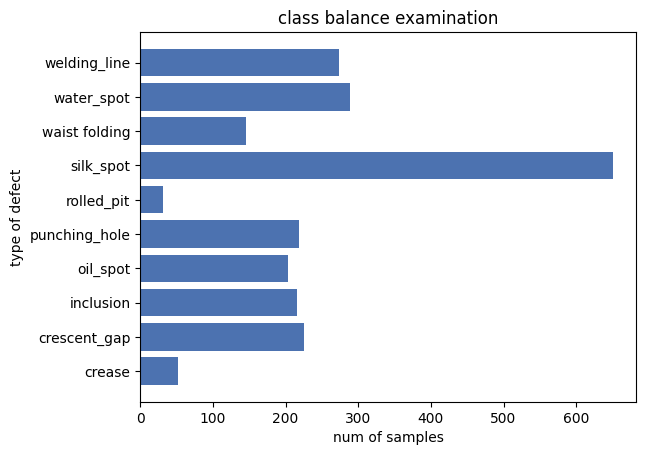

In [11]:
### show balance of dataset

import os
import matplotlib.pyplot as plt


# Get a list of the subdirectories within the parent directory
subdirectories = [subdir for subdir in os.listdir(image_directory) if os.path.isdir(os.path.join(image_directory, subdir))]

# Initialize lists to store folder names and corresponding file counts
folder_names = []
file_counts = []

# Iterate over the subdirectories and count the number of files in each folder
for subdir in subdirectories:
    folder_path = os.path.join(image_directory, subdir)
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    folder_names.append(subdir)
    file_counts.append(len(files))

# Plotting the results
plt.barh(folder_names, file_counts,color = '#4c72b0')
plt.xlabel('num of samples')
plt.ylabel('type of defect')
plt.title('class balance examination')
#plt.xticks(rotation=90)
plt.show()


Name            | xmin/ymin | xmax/ymax
punching_hole   | ( 100, 704) | ( 218, 771)
welding_line    | (   3, 532) | (2045, 600)


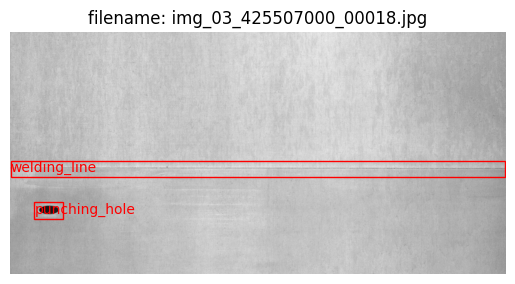

In [12]:
visualize_data(df,'random')

In [23]:
df['bounding_boxes'][0]

[[8, 981, 182, 2046, 249], [8, 478, 179, 711, 244]]

In [30]:
x = [[8, 981, 182, 2046, 249], [8, 478, 179, 711, 244]]
print(x+ [[0,0,0,0,0]]* (5 - len(x)))

[[8, 981, 182, 2046, 249], [8, 478, 179, 711, 244], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]


In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the original list of lists
original_list = [[x], [y]]

# Define the desired length for padding
desired_length = 4

# Pad the list of lists
padded_list = pad_sequences(original_list, maxlen=desired_length, padding='post', value=0)

print(padded_list)

ModuleNotFoundError: No module named 'tensorflow'